In [20]:
import time
import datetime
import random
import pandas as pd 
import pickle
import json
import requests
from io import BytesIO
from itertools import repeat

from pytimekr import pytimekr
import yfinance as yf
import pykrx
import dart_fss
from fredapi import Fred
import talib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import plotly.graph_objects as go

from yf_func import *
from krx_func import *
from utils import *

plt.rcParams["figure.figsize"] = (22, 6)

OPENDART_APIKEY = "f15d5e316baebf5fa004412c2feefb4a8dd65745"
dart_fss.set_api_key(api_key=OPENDART_APIKEY)

FRED_API_KEY = "89ac04db790be30df44979764e3aaf69"

# Data download

In [2]:
fred = Fred(api_key=FRED_API_KEY)
high_yield_spread = fred.get_series("BAMLH0A0HYM2EY").dropna()

aaa = fred.get_series("AAA").dropna()
baa = fred.get_series("BAA").dropna()
interest_rate_diff = baa - aaa

# start = high_yield_spread.index[0].strftime("%Y-%m-%d")
# end = high_yield_spread.index[-1].strftime("%Y-%m-%d")
start = "1980-01-01"

nasdaq_100 = yf.download("^NDX", start=start)
snp_500 = yf.download("^GSPC", start=start)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
interest_rate_diff_daily = interest_rate_diff.resample('D').asfreq()
interest_rate_diff_daily = interest_rate_diff_daily.interpolate(method='linear')

# EDA

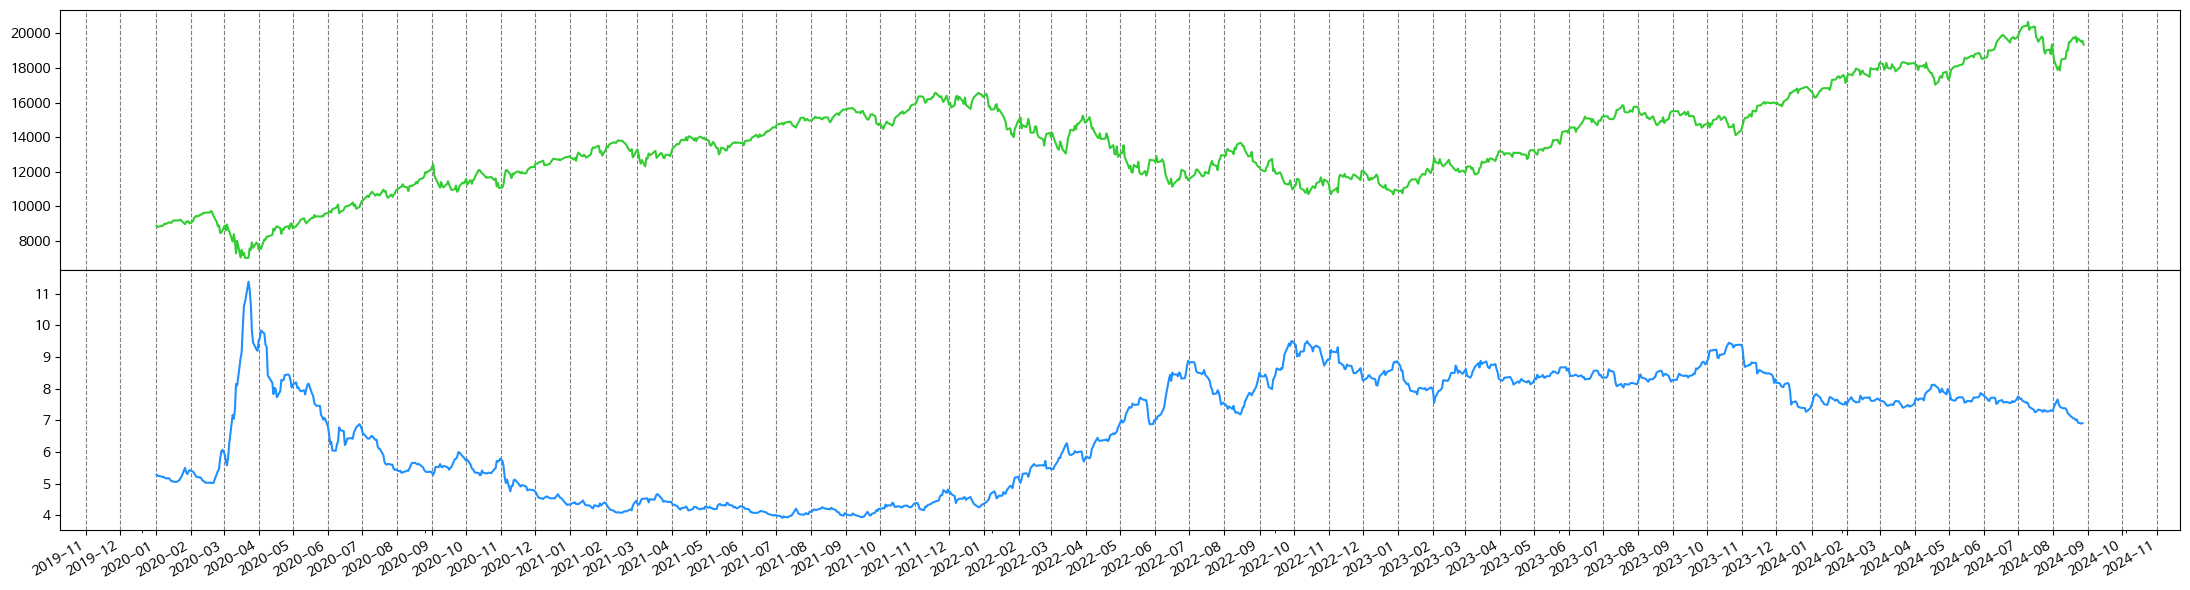

In [27]:
start = "2020-01-01"
end = "2024-12-31"

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0})
nasdaq_100["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
# snp_500["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
high_yield_spread.loc[start: end].plot(ax=ax1, color='dodgerblue')

ax0.set_axisbelow(True)
ax0.xaxis.grid(color='gray', linestyle='dashed')
# ax0.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
# ax1.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()

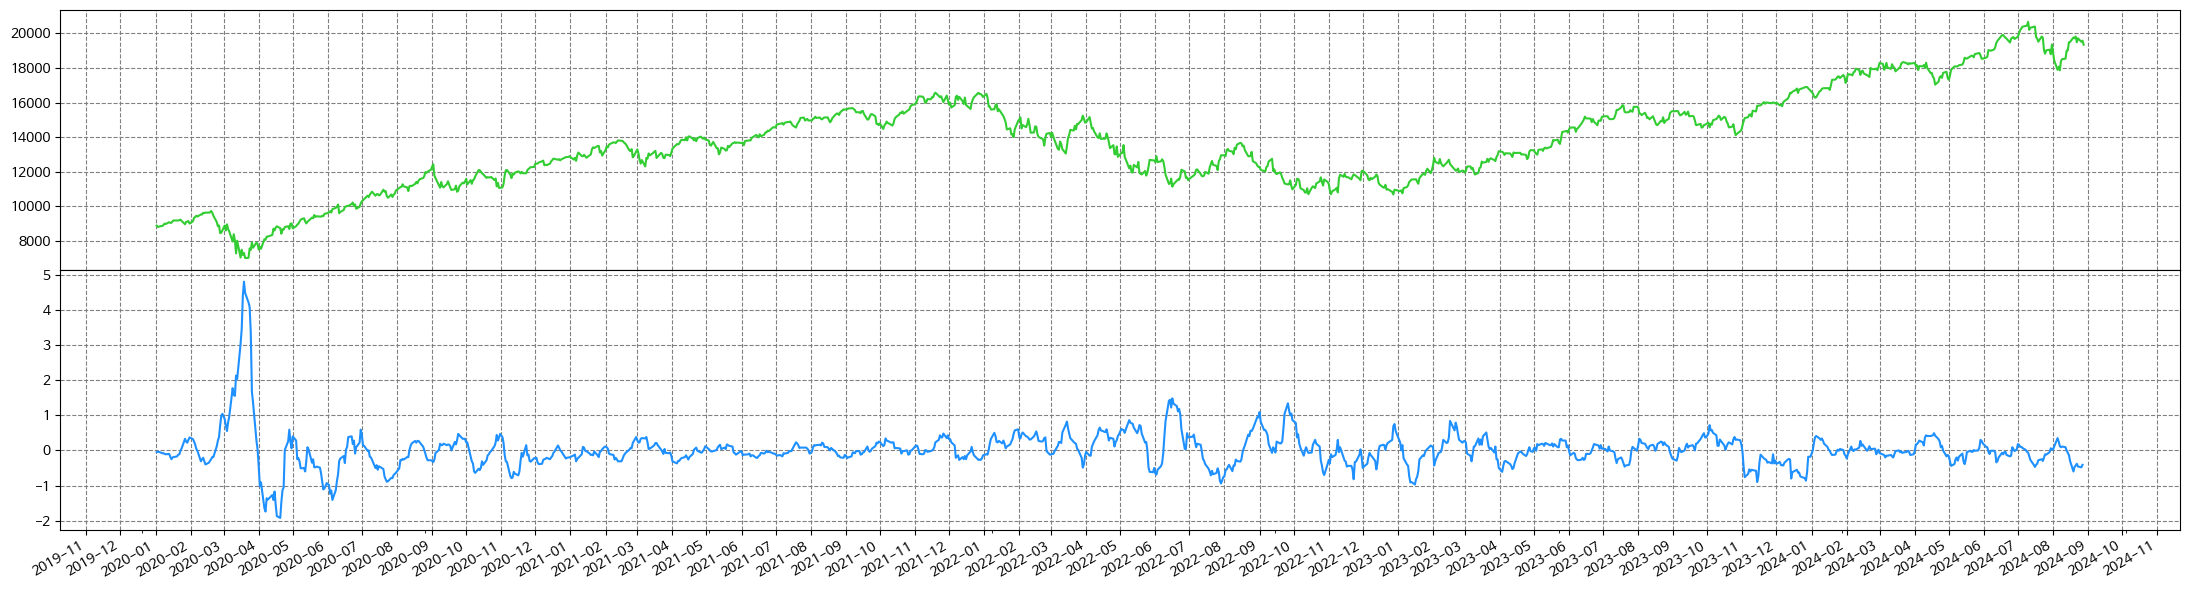

In [32]:
momentum = talib.MOM(high_yield_spread)

start = "2020-01-01"
end = "2024-12-31"

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0})
nasdaq_100["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
# snp_500["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
momentum.loc[start: end].plot(ax=ax1, color='dodgerblue')

ax0.set_axisbelow(True)
ax0.xaxis.grid(color='gray', linestyle='dashed')
ax0.yaxis.grid(color='gray', linestyle='dashed')
# ax0.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')
# ax1.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()

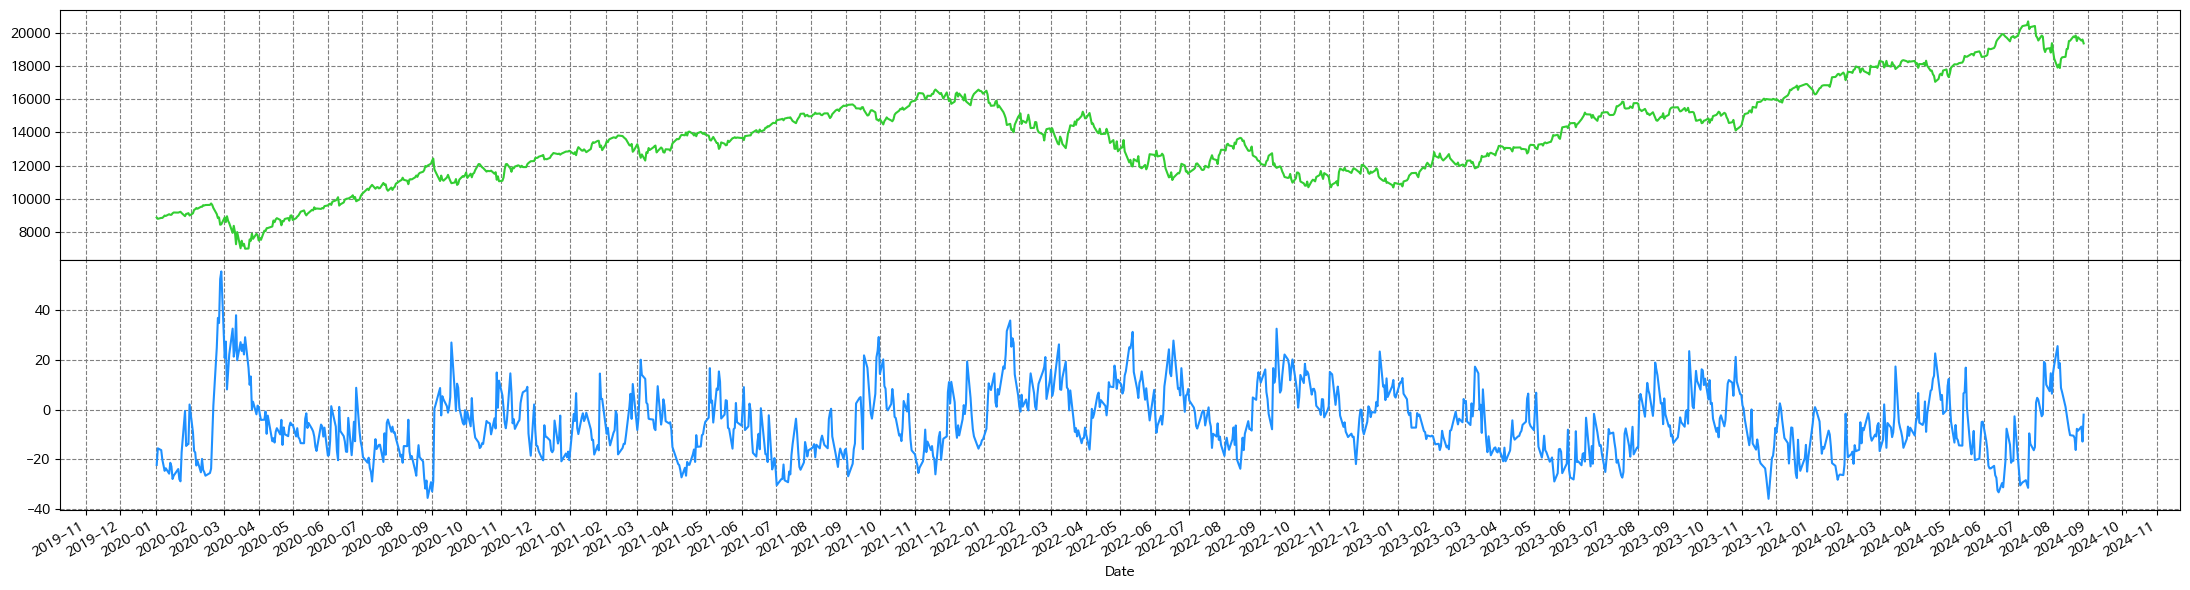

In [39]:
price_rsi = talib.RSI(nasdaq_100["Close"], timeperiod=14)
volume_rsi = talib.RSI(nasdaq_100["Volume"], timeperiod=14)
divergence = volume_rsi - price_rsi

start = "2020-01-01"
end = "2024-12-31"

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0})
nasdaq_100["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
# snp_500["Close"].loc[start: end].plot(ax=ax0, color='limegreen')
divergence.loc[start: end].plot(ax=ax1, color='dodgerblue')

ax0.set_axisbelow(True)
ax0.xaxis.grid(color='gray', linestyle='dashed')
ax0.yaxis.grid(color='gray', linestyle='dashed')
# ax0.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')
# ax1.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()

# backtesting.py

In [40]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

import talib

In [41]:
data = yf.download("TQQQ", start="2010-01-01", end="2020-3-31")

[*********************100%%**********************]  1 of 1 completed


In [45]:
price_rsi = talib.RSI(nasdaq_100["Close"], timeperiod=14)
volume_rsi = talib.RSI(nasdaq_100["Volume"], timeperiod=14)
divergence = volume_rsi - price_rsi

In [46]:
class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 3
    n2 = 220
    
    def init(self):
        # Precompute the two moving averages
        # self.price = self.I(lambda x:x, self.data.Close)
        self.sma1 = self.I(talib.SMA, self.data.Close, self.n1)
        self.sma2 = self.I(talib.SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

In [47]:
bt = Backtest(data, SmaCross, cash=100000, commission=.01, trade_on_close=True)
stats = bt.run()
print(stats)

Start                     2010-02-11 00:00:00
End                       2020-03-30 00:00:00
Duration                   3700 days 00:00:00
Exposure Time [%]                   70.470588
Equity Final [$]                838125.573256
Equity Peak [$]                1398370.369037
Return [%]                         738.125573
Buy & Hold Return [%]              2732.02938
Return (Ann.) [%]                   23.379971
Volatility (Ann.) [%]               49.060524
Sharpe Ratio                         0.476554
Sortino Ratio                        0.834116
Calmar Ratio                         0.485704
Max. Drawdown [%]                   -48.13624
Avg. Drawdown [%]                   -6.466843
Max. Drawdown Duration      742 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                   14
Win Rate [%]                        28.571429
Best Trade [%]                     232.496771
Worst Trade [%]                     -13.18365
Avg. Trade [%]                    

In [ ]:
print(f"Total Return: {stats['Return [%]']}, CAGR: {stats['Return (Ann.) [%]']}, MDD: {stats['Max. Drawdown [%]']}")

In [ ]:
bt.plot()

# mplfinance Simple Chart

In [ ]:
cond = (nasdaq_100.index >= "2012") & (nasdaq_100.index <= "2015")
mpf.plot(nasdaq_100[cond], type="line", mav=(3, 200), volume=True)

# Plotly

In [3]:
df = nasdaq_100.copy()
df["MA5"] = df["Close"].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA60'] = df['Close'].rolling(window=60).mean()
df['MA120'] = df['Close'].rolling(window=120).mean()

In [ ]:
fig = go.Figure()
fig.update_layout(
    # 제목  
    title = '삼성전자 주가',
    title_font_family="맑은고딕",
    title_font_size = 18,
    # hover 배경
    hoverlabel=dict(
        bgcolor='black',
        font_size=15,
    ),
    # hover mode 변경
    hovermode="x unified",
    # 테마
    template='plotly_dark',
    # X축 각도
    xaxis_tickangle=90,
    # Y 축 포맷
    yaxis_tickformat = ',',
    # 범례
    legend = dict(orientation = 'h', xanchor = "center", x = 0.85, y= 1.1), 
    barmode='group',
    # 여백
    margin=go.layout.Margin(
        l=10, #left margin
        r=10, #right margin
        b=10, #bottom margin
        t=50  #top margin
    ),
    # 길이
    height=600, width=800, 
    showlegend=False, 
    xaxis_rangeslider_visible=False
) 

In [ ]:
# Base
fig.add_trace(go.Candlestick(
    x=nasdaq_100.index,
    open=nasdaq_100['Open'],
    high=nasdaq_100['High'],
    low=nasdaq_100['Low'],
    close=nasdaq_100['Close'],
    increasing_line_color= 'red', decreasing_line_color= 'blue')
)

# MA 5 
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['MA5'],
    opacity=0.7,
    line=dict(color='blue', width=2),
    name='MA 5'))

# MA 20
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['MA20'],
    opacity=0.7,
    line=dict(color='orange', width=2),
    name='MA 20'))

# MA 60
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['MA60'],
    opacity=0.7,
    line=dict(color='purple', width=2),
    name='MA 60'))

# MA 120
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['MA120'],
    opacity=0.7,
    line=dict(color='green', width=2),
    name='MA 120'))